<center><h1>Are there any Alpaca here?</h1></center>
<center><img src="https://i.imgur.com/z28dYsy.jpeg" width="1000px" height="100px"></center>

## Table of Content

- [1 - Investigate and Create Workspace](#1)
    - [1.1 Import Packages](#1-1)
    - [1.2 Investigate Files and choose optimal sizes](#1-2)
    - [1.3 Create the Dataset and Split it into Training and Validation Sets](#1-3)
- [2 - Preprocess and Augment Training Data](#2)
    - [2.1 Check Labels of Images](#2-1)
    - [2.2 data_augmentation](#2-2)
- [3 - Using InceptionV3 for Transfer Learning](#3)
    - [3.1 - Show a InceptionV3 Convolutional Building Block](#3-1)
    - [3.2 - Building Model with Transfer Learning InceptionV3](#3-2)
        - [3.2.1 - Building Final Edition Model](#3-2-1)
        - [3.2.2 - Train Model on our Data](#3-2-2)
    - [3.3 - Evaluate Model](#3-3)

<a name='1'></a>
# 1 - Investigate and Create Workspace

<a name='1-1'></a>
## 1.1 Import Packages

In [1]:
import os
import numpy as np
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random


import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

sns.set()
%matplotlib inline

In [2]:
#file path
directory = '../input/alpaca-dataset-small/dataset/'

<a name='1-2'></a>

## 1.2 Investigate Files and choose optimal sizes

In [3]:
for folder in  os.listdir(directory) : 
    files = gb.glob(pathname= str( directory + folder + '/*.jpg'))
    print(f'Found {len(files)} in folder {folder}')

Found 185 in folder not alpaca
Found 142 in folder alpaca


In [4]:
size = []
for folder in  os.listdir(directory) : 
    files = gb.glob(pathname= str( directory + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
print(f'The Total images we have : {len(size)}')
print(pd.Series(size).value_counts())

The Total images we have : 327
(768, 1024, 3)    113
(683, 1024, 3)     46
(1024, 768, 3)     13
(680, 1024, 3)     13
(682, 1024, 3)     10
                 ... 
(652, 1024, 3)      1
(1024, 720, 3)      1
(716, 1024, 3)      1
(532, 1024, 3)      1
(847, 1024, 3)      1
Length: 89, dtype: int64


> - We can see the average height of the all image is 1024 and Width is 700 
so we can compress the images to 160x160 

<a name='1-3'></a>

## 1.3 Create the Dataset and Split it into Training and Validation Sets

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=30)
val_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=30)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


<a name='2'></a>
# 2 - Preprocess and Augment Training Data

<a name='2-1'></a>
## 2.1 Check Labels of Images

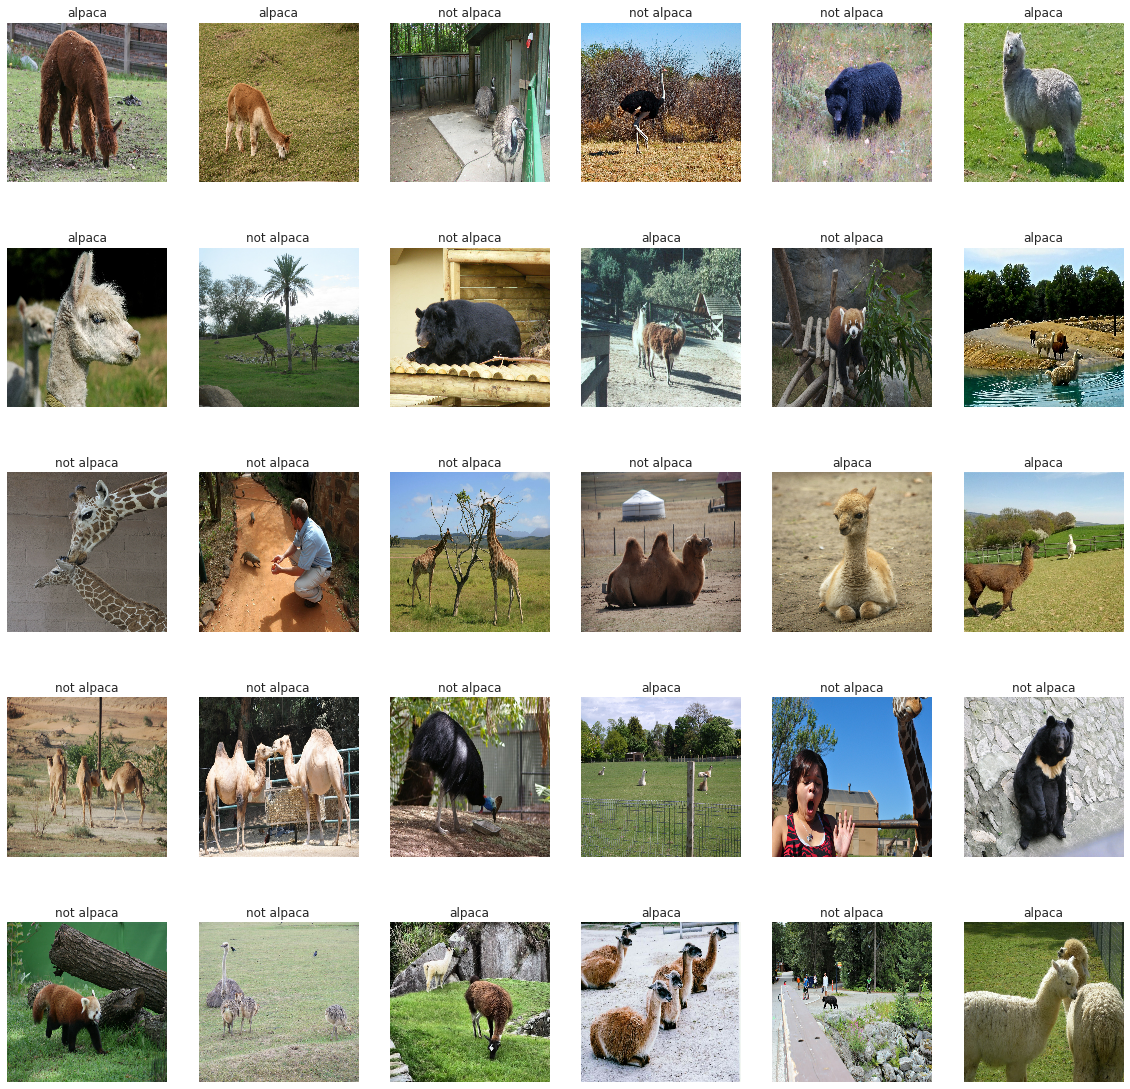

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(20,20))
for images, labels in train_dataset.take(1):
    for i in range(30):
        ax = plt.subplot(5,6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

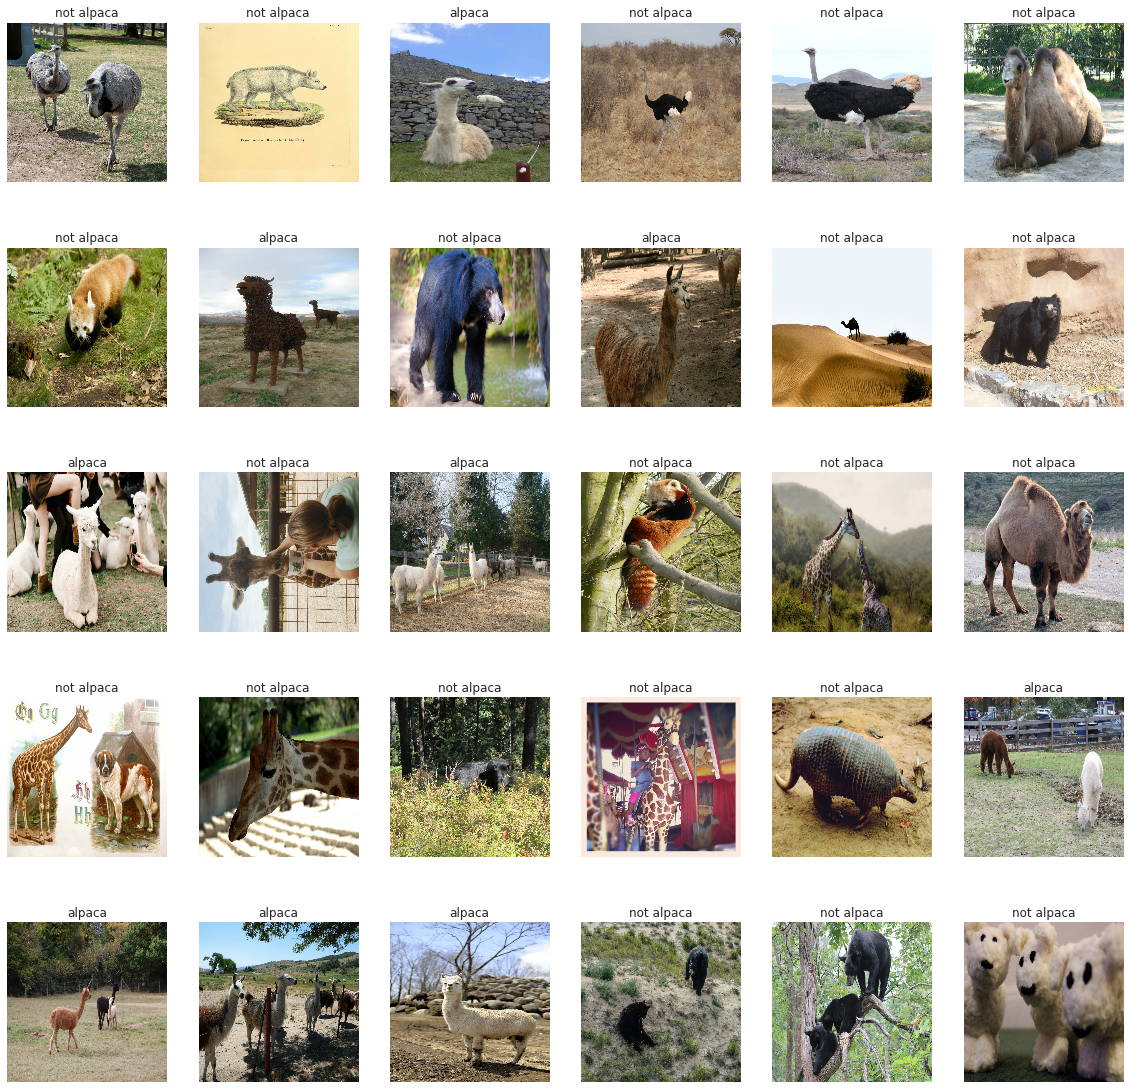

In [9]:
class_names = val_dataset.class_names

plt.figure(figsize=(20,20))
for images, labels in val_dataset.take(1):
    for i in range(30):
        ax = plt.subplot(5,6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2-2'></a>
## 2.2 Data Augmentation

In [10]:
#Make a Function to make Data Augmentation reuse it whenever we want
def data_augmenter():
    #Create a Sequential model composed of 2 layers
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [11]:
#For memory use
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

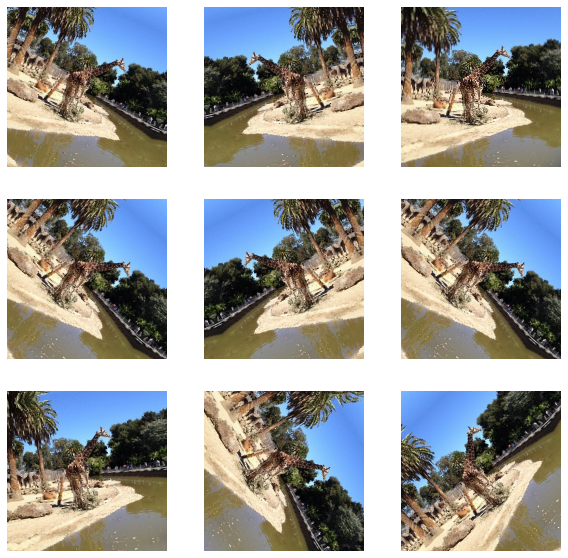

In [12]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [25]:
#Take preprocessing function from module inception_v3 
preprocess_input = tf.keras.applications.inception_v3.preprocess_input 

<a name='3'></a>

# 3 - Using InceptionV3 for Transfer Learning

<img src="https://i.imgur.com/AkpDrWn.png" width="1100px" height="200px">


In [26]:
#Model InceptionV3 On 
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=input_shape,
                                               include_top=False, # To remove the last 2 layers ==>Classifier layer!!!!
                                               weights='imagenet') # From imageNet

<a name='3-1'></a>

## 3.1 - Show a InceptionV3 Convolutional Building Block

In [27]:
#model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 79, 79, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 79, 79, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 79, 79, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

<a name='3-2'></a>

## 3.2 - Building Model with Transfer Learning InceptionV3

<img src="https://i.imgur.com/rdfLTFX.jpeg" width="1000px" height="200px">

In [28]:
#To train the parameters ==> True..... to Freeze parameters ==> False 
base_model.trainable = True
# create the input layer (Same as the InceptionV3 input size)
inputs = tf.keras.Input(shape=input_shape) 

# apply data augmentation to the inputs
x = data_augmentation(inputs)

# data preprocessing using the same weights the model was trained on
x = preprocess_input(x) 

# set training to False to avoid keeping track of statistics in the batch norm layer
x = base_model(x, training=False) 

# add the new Binary classification layers
# use global avg pooling to summarize the info in each channel
x = tfl.GlobalAveragePooling2D()(x) 
# include dropout with probability of 0.5 to avoid overfitting
x = tfl.Dropout(0.2)(x)

# use a prediction layer with one neuron (as a binary classifier only needs one)
outputs = tfl.Dense(1)(x)
# create model 
model = tf.keras.Model(inputs, outputs)

In [30]:
#model architecture
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

<a name='3-2-1'></a>
## 3.2.1 Building Final Edition Model

In [31]:
#take a base_model from model we created with 4 layers --> last 4 layers for classifier 
base_model = model.layers[4]
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 280


# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
learning_rate = 0.001
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate 
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']
#Put all this hyperparameters in the model
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  311


<a name='3-2-2'></a>
## Train Model on our Data

In [32]:
#number of epochs = 10
epochs =  10
#train model
history = model.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset)

Epoch 1/10
9/9 [==============================] - 17s 1s/step - loss: 2.9278 - accuracy: 0.7176 - val_loss: 0.5180 - val_accuracy: 0.8308
Epoch 2/10
9/9 [==============================] - 9s 916ms/step - loss: 0.3653 - accuracy: 0.8473 - val_loss: 0.4339 - val_accuracy: 0.8154
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.2804 - accuracy: 0.8931 - val_loss: 0.3920 - val_accuracy: 0.8923
Epoch 4/10
9/9 [==============================] - 9s 902ms/step - loss: 0.1363 - accuracy: 0.9313 - val_loss: 0.3074 - val_accuracy: 0.9077
Epoch 5/10
9/9 [==============================] - 9s 906ms/step - loss: 0.1604 - accuracy: 0.9389 - val_loss: 0.2817 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 9s 961ms/step - loss: 0.1340 - accuracy: 0.9504 - val_loss: 0.2427 - val_accuracy: 0.9077
Epoch 7/10
9/9 [==============================] - 9s 921ms/step - loss: 0.0998 - accuracy: 0.9504 - val_loss: 0.2424 - val_accuracy: 0.9077
Epoch 8/10
9/9 [========

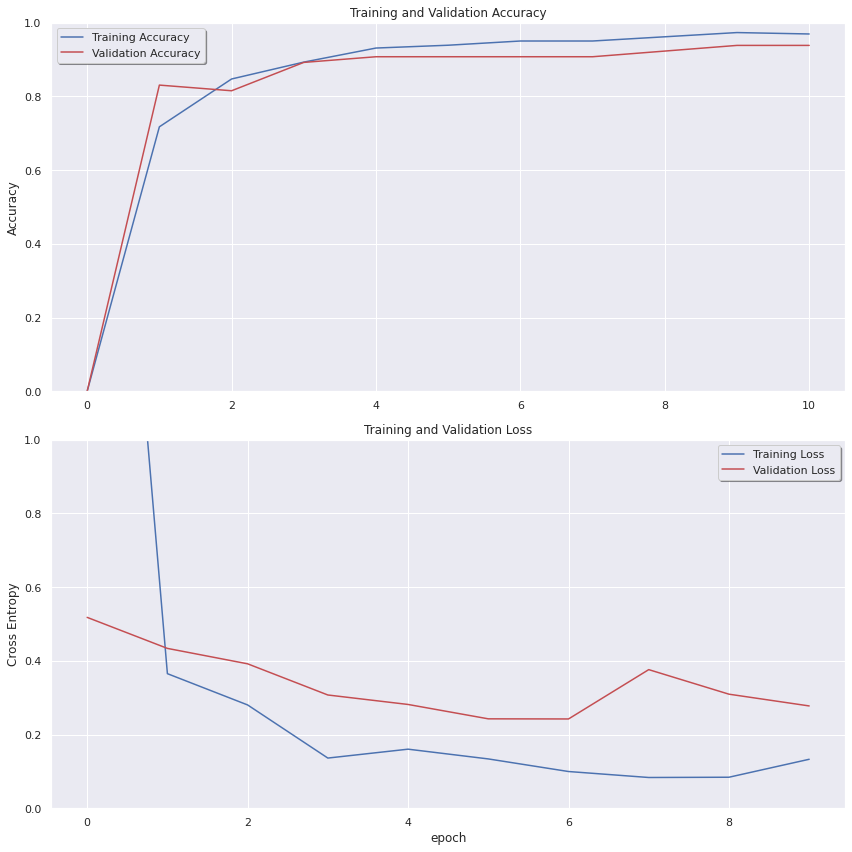

In [33]:
sns.set()
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Plot Training Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(acc, color='b', label='Training Accuracy')
ax1.plot(val_acc, color='r', label='Validation Accuracy')
ax1.set_ylim([0, 1])
#make Legend
ax1.legend(loc='best', shadow=True)
#put label name 
ax1.set_ylabel('Accuracy')
#put title name
ax1.set_title('Training and Validation Accuracy')


#Plot Training Loss
ax2.plot(loss, color='b', label='Training Loss')
ax2.plot(val_loss, color='r', label='Validation Loss')
ax2.set_ylim([0, 1])

#make Legend
ax2.legend(loc='best', shadow=True)
#put label name 
ax2.set_ylabel('Cross Entropy')
ax2.set_xlabel('epoch')
#put label name 
ax2.set_title('Training and Validation Loss')
plt.tight_layout()
plt.show()

In [34]:
#Make more 5 epochs
more_epochs = 5
total_epochs =  epochs + more_epochs
#Train model on more 5 epochs
history_More = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 10/15
9/9 [==============================] - 10s 998ms/step - loss: 0.0620 - accuracy: 0.9695 - val_loss: 0.2798 - val_accuracy: 0.9385
Epoch 11/15
9/9 [==============================] - 9s 922ms/step - loss: 0.1088 - accuracy: 0.9618 - val_loss: 0.2999 - val_accuracy: 0.9385
Epoch 12/15
9/9 [==============================] - 9s 942ms/step - loss: 0.0642 - accuracy: 0.9771 - val_loss: 0.3301 - val_accuracy: 0.9385
Epoch 13/15
9/9 [==============================] - 9s 902ms/step - loss: 0.0526 - accuracy: 0.9809 - val_loss: 0.3091 - val_accuracy: 0.9231
Epoch 14/15
9/9 [==============================] - 10s 989ms/step - loss: 0.0354 - accuracy: 0.9847 - val_loss: 0.3602 - val_accuracy: 0.9385
Epoch 15/15
9/9 [==============================] - 9s 907ms/step - loss: 0.0635 - accuracy: 0.9733 - val_loss: 0.3057 - val_accuracy: 0.9385


<a name='4'></a>
# 4 - Evaluation Model

In [35]:
#add more epochs to plot
acc += history_More.history['accuracy']
val_acc += history_More.history['val_accuracy']

loss += history_More.history['loss']
val_loss += history_More.history['val_loss']


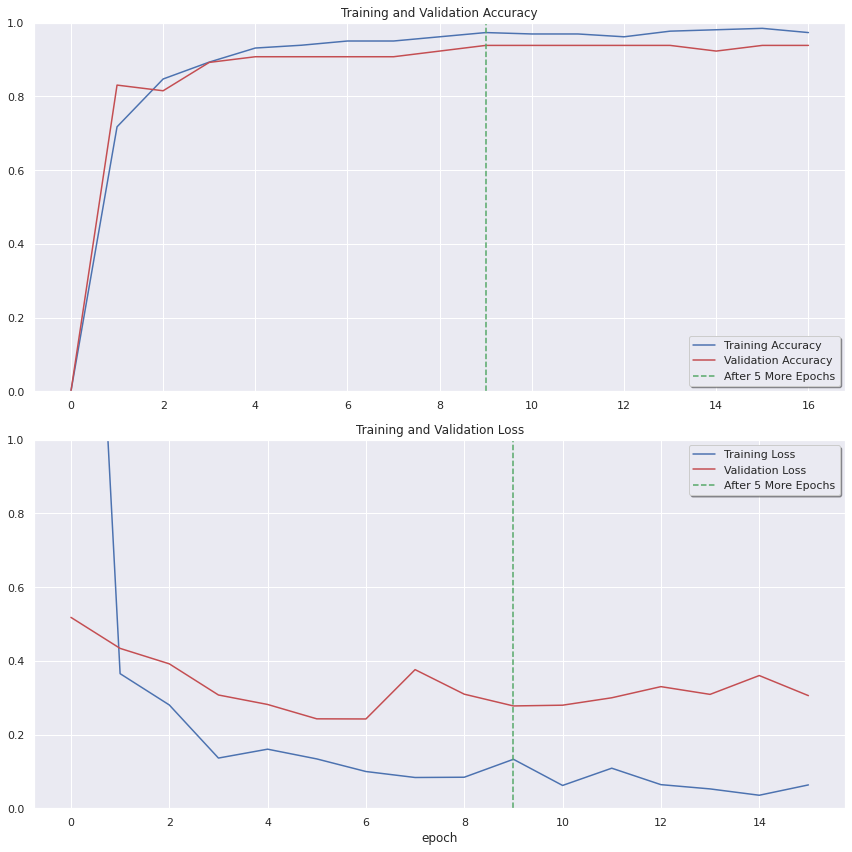

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(acc, color='b',  label='Training Accuracy')
ax1.plot(val_acc, color='r',  label='Validation Accuracy')
ax1.set_ylim([0, 1])
ax1.plot([epochs-1,epochs-1],
          plt.ylim(), 'g--', label='After 5 More Epochs')
ax1.legend(loc='best', shadow=True)
ax1.set_title('Training and Validation Accuracy')

ax2.plot(loss, color='b',  label='Training Loss')
ax2.plot(val_loss, color='r', label='Validation Loss')
ax2.set_ylim([0, 1.0])
ax2.plot([epochs-1,epochs-1],
         plt.ylim(), 'g--', label='After 5 More Epochs')
ax2.legend(loc='best', shadow=True)
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')
plt.tight_layout()
plt.show()

In [40]:
model.save('v1_alpaca_model.h5')

In [41]:
model.save_weights('v1_alpaca_weights.h5')